In [1]:
# 🥇 Step 0: 라이브러리 설치 및 임포트
!pip install feature-engine

# 📊 데이터 분석 및 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import pandas as pd

# 🤖 머신러닝 관련 라이브러리
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# 🛠 기타 유틸
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 3.2 MB/s eta 0:00:00


In [3]:
# 📊 Step 1: 데이터 로드 및 기본 정보 확인
df = pd.read_csv("/content/drive/MyDrive/loan_data.csv")
df.info()

# 🔧 나이 컬럼 타입 변환
df['나이'] = df['나이'].astype('int')

# 🔍 범주형 / 수치형 컬럼 구분
cat_cols = [var for var in df.columns if df[var].dtypes == 'object']
num_cols = [var for var in df.columns if df[var].dtypes != 'object']
print(f'Categorical columns: {cat_cols}')
print(f'Numerical columns: {num_cols}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   나이            45000 non-null  float64
 1   성별            45000 non-null  object 
 2   교육 수준         45000 non-null  object 
 3   연 소득          45000 non-null  float64
 4   근무 경력(년)      45000 non-null  int64  
 5   주택 소유 형태      45000 non-null  object 
 6   대출 금액         45000 non-null  float64
 7   대출 목적         45000 non-null  object 
 8   대출 이자율        45000 non-null  float64
 9   소득 대비 대출금 비율  45000 non-null  float64
 10  신용 이력 길이(년)   45000 non-null  float64
 11  신용 점수         45000 non-null  int64  
 12  과거 대출 연체 여부   45000 non-null  object 
 13  대출 승인 여부      45000 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 4.8+ MB
Categorical columns: ['성별', '교육 수준', '주택 소유 형태', '대출 목적', '과거 대출 연체 여부']
Numerical columns: ['나이', '연 소득', '근무 경력(년)', '대출 금액', '대출 이자율', '소득

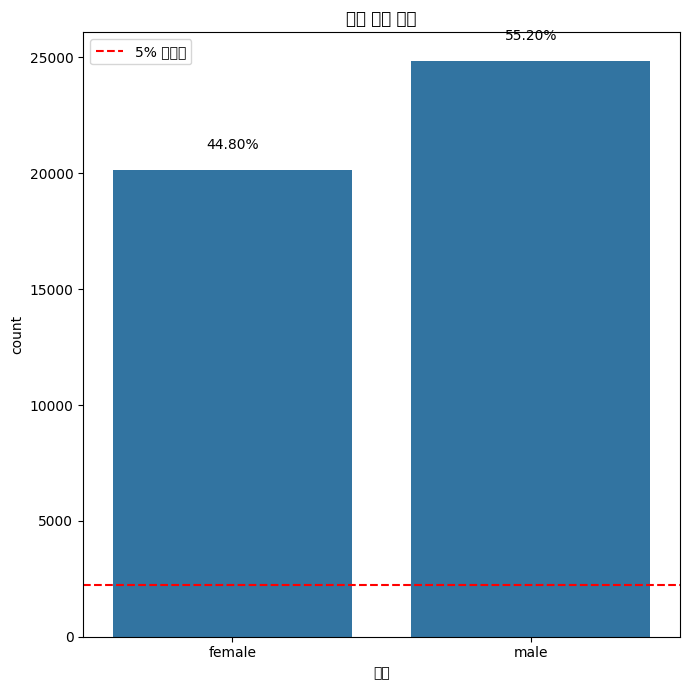

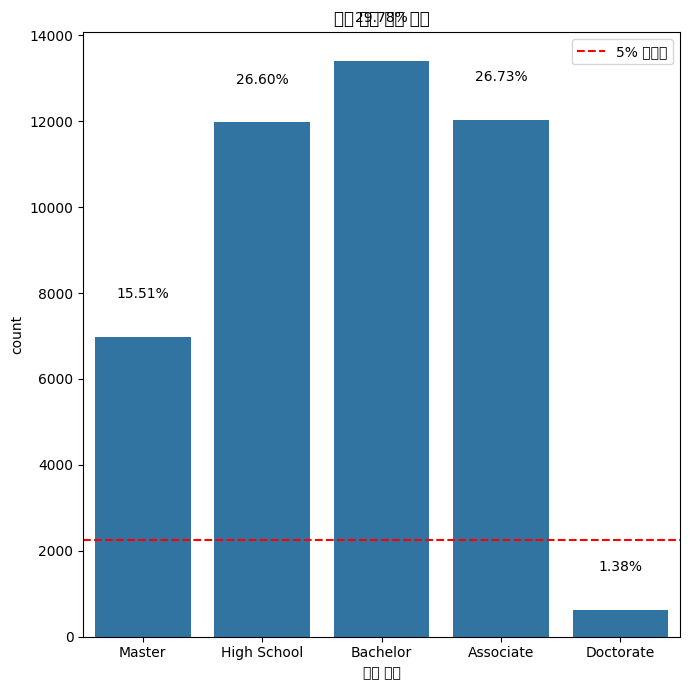

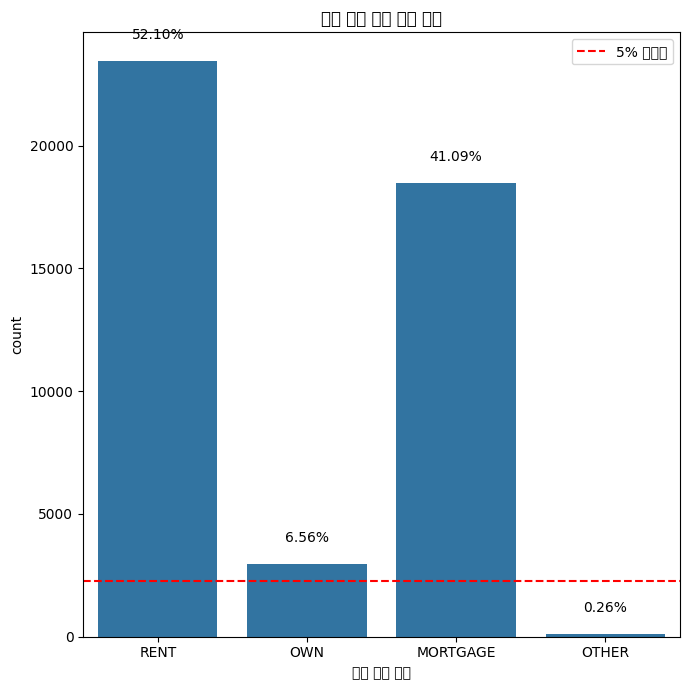

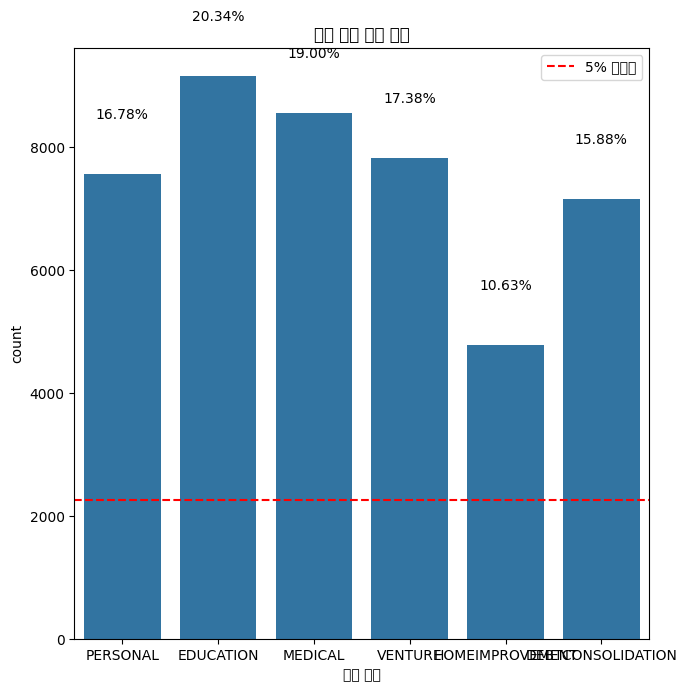

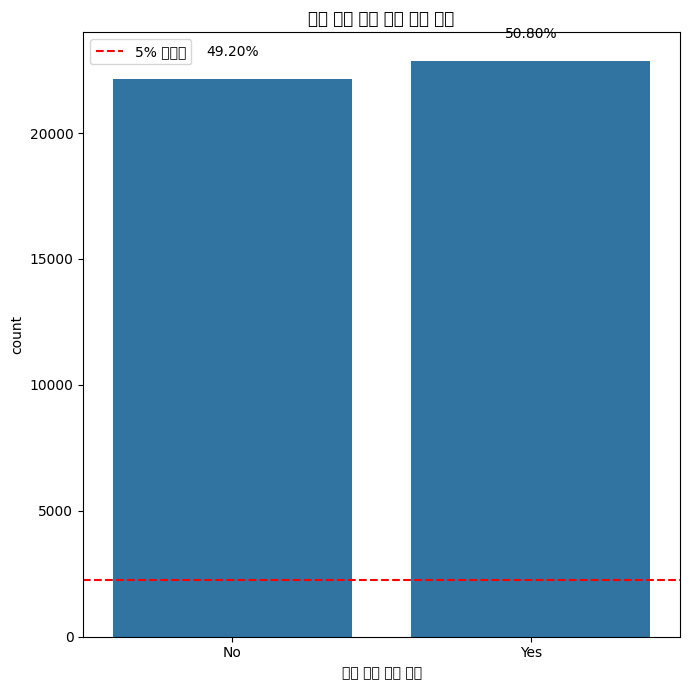

In [4]:
# 📊 Step 2: 범주형 변수 분포 시각화

def plot_categorical_column(dataframe, column):
    plt.figure(figsize=(7, 7))
    ax = sns.countplot(x=dataframe[column])
    total_count = len(dataframe[column])
    threshold = 0.05 * total_count
    category_counts = dataframe[column].value_counts(normalize=True) * 100

    # 기준선 추가
    ax.axhline(threshold, color='red', linestyle='--', label=f'5% 기준선')

    # 각 막대 위에 비율 표기
    for p in ax.patches:
        height = p.get_height()
        percentage = (height / total_count) * 100
        ax.text(p.get_x() + p.get_width() / 2., height + 0.02 * total_count, f'{percentage:.2f}%', ha="center")

    plt.title(f'{column} 변수 분포')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 모든 범주형 변수 시각화
for col in cat_cols:
    plot_categorical_column(df, col)


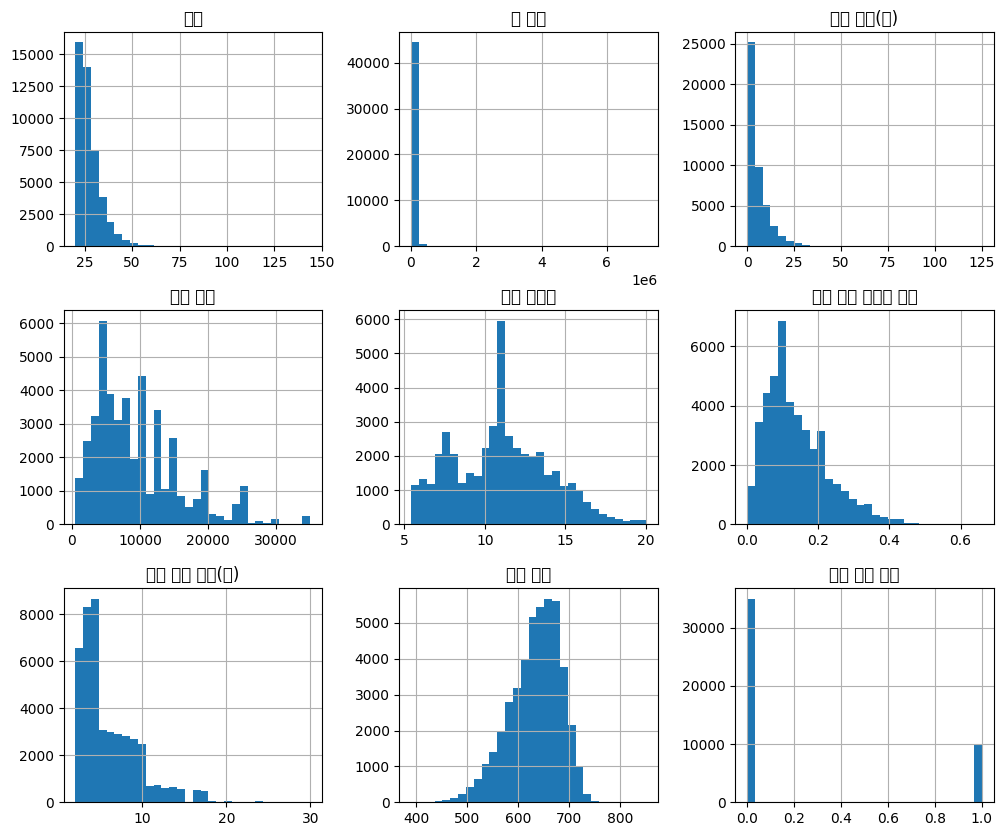

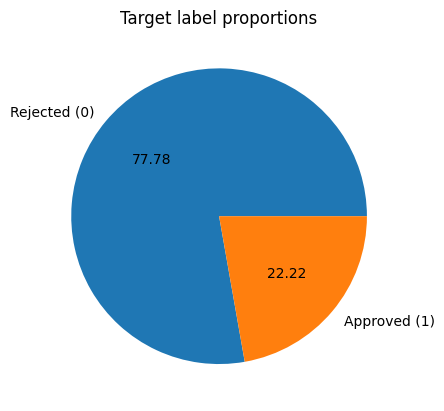

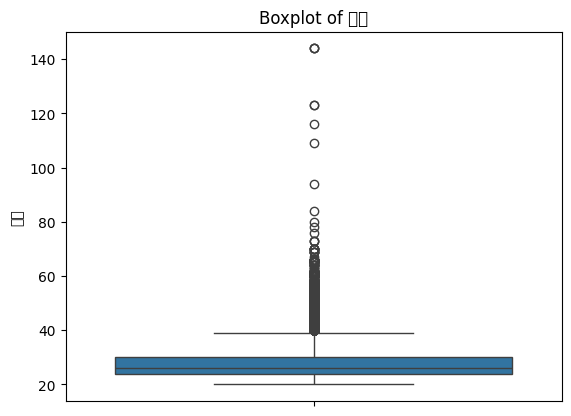

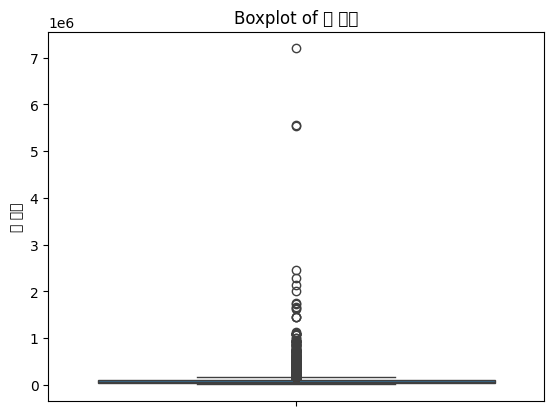

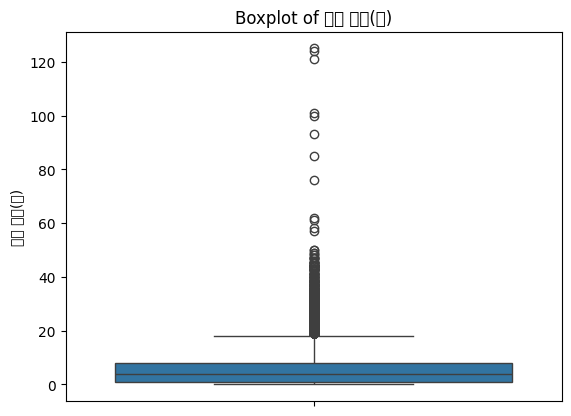

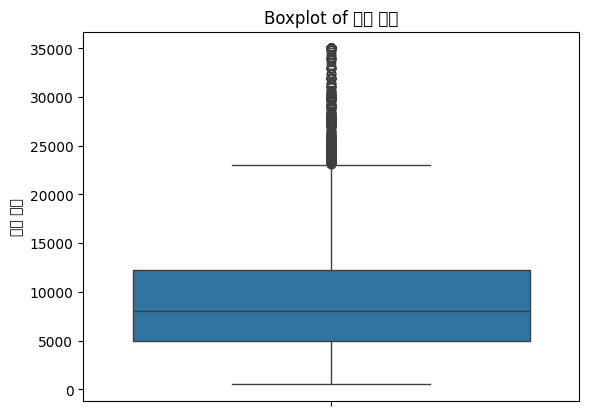

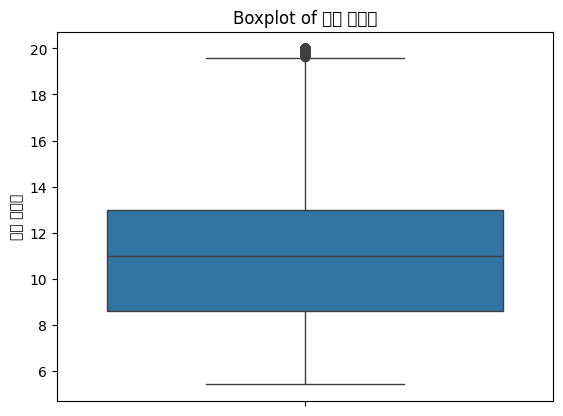

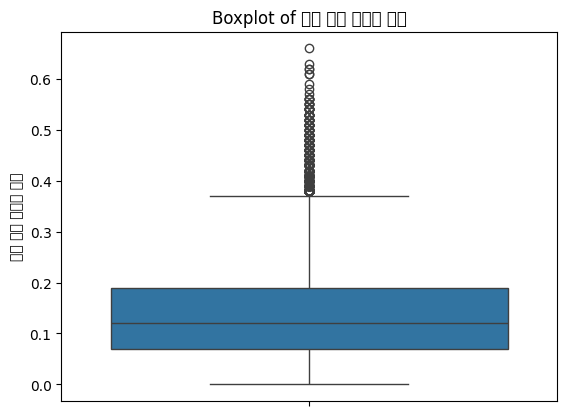

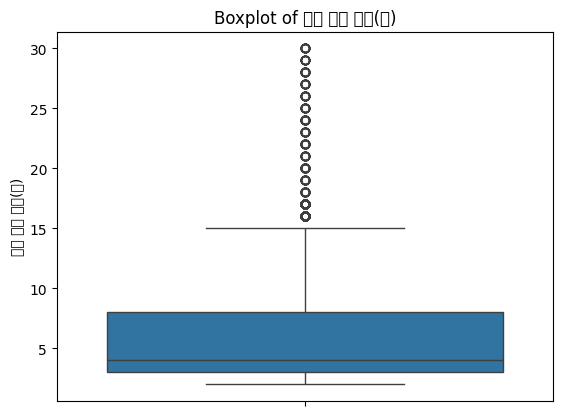

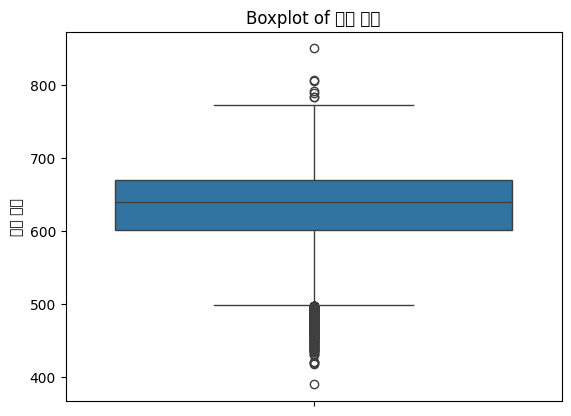

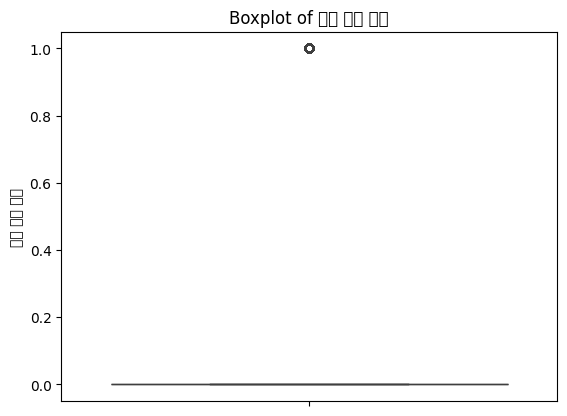

In [5]:
# 📊 Step 3: 수치형 변수 분포 및 타겟 변수 시각화
# 히스토그램
df[num_cols].hist(bins=30, figsize=(12,10))
plt.show()

# 타겟 분포 파이차트
label_prop = df['대출 승인 여부'].value_counts()
plt.pie(label_prop.values, labels=['Rejected (0)', 'Approved (1)'], autopct='%.2f')
plt.title('Target label proportions')
plt.show()

# 박스플롯 (이상치 탐지)
for col in num_cols:
    sns.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [6]:
# Step 4: 데이터 정규화 (표준화 + 정규화)
skewed_cols = ['나이', '연 소득', '근무 경력(년)',
               '대출 금액', '소득 대비 대출금 비율',
               '신용 이력 길이(년)', '신용 점수']
norm_cols = ['대출 이자율']

mms = MinMaxScaler()
ss = StandardScaler()

df[skewed_cols] = ss.fit_transform(df[skewed_cols])
df[norm_cols] = mms.fit_transform(df[norm_cols])

In [7]:
# 🔢 Step 5: 범주형 변수 수치화 (Label Encoding)
df['교육 수준'].replace({
    'High School': 0, 'Associate': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4
}, inplace=True)

gender_mapping = {'male': 0, 'female': 1}
home_ownership_mapping = {'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3}
loan_intent_mapping = {'PERSONAL': 0, 'EDUCATION': 1, 'MEDICAL': 2, 'VENTURE': 3,
                       'HOMEIMPROVEMENT': 4, 'DEBTCONSOLIDATION': 5}
previous_loan_defaults_mapping = {'No': 0, 'Yes': 1}

df['성별'] = df['성별'].map(gender_mapping)
df['주택 소유 형태'] = df['주택 소유 형태'].map(home_ownership_mapping)
df['대출 목적'] = df['대출 목적'].map(loan_intent_mapping)
df['과거 대출 연체 여부'] = df['과거 대출 연체 여부'].map(previous_loan_defaults_mapping)

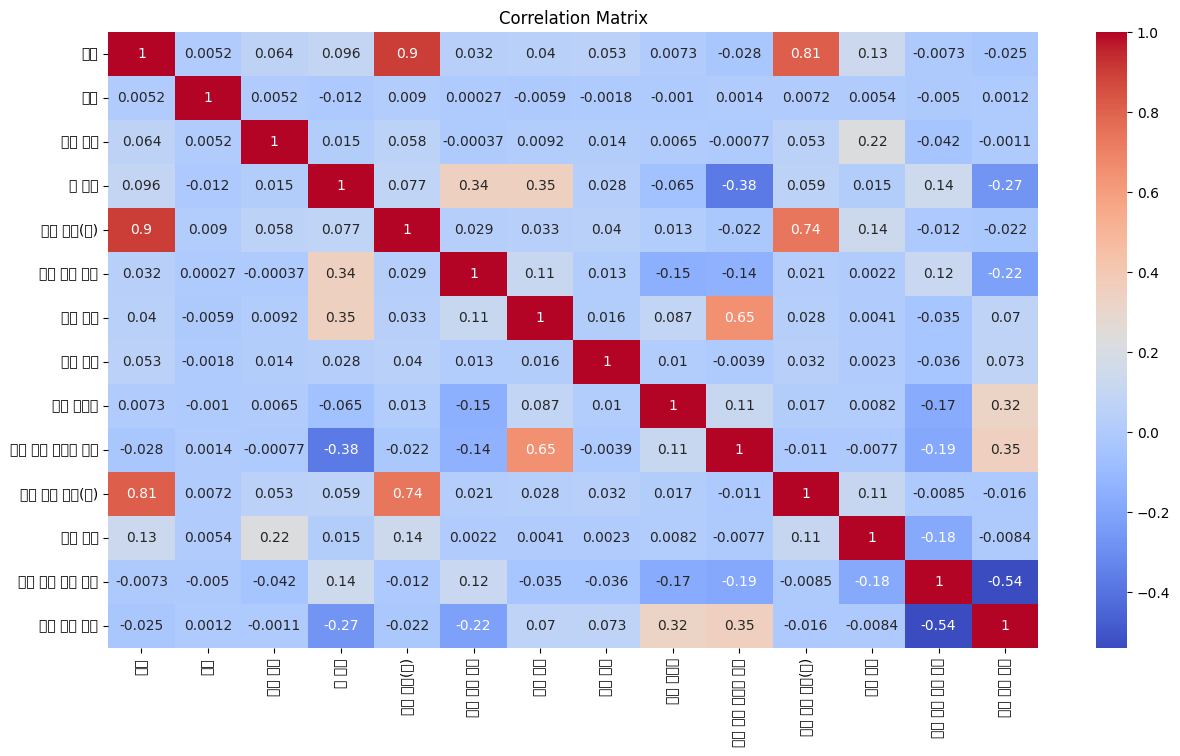

In [8]:
# Step 6: 이상치 제거 (Feature-engine 사용)
from feature_engine.outliers import OutlierTrimmer

trimmer = OutlierTrimmer(
    capping_method='iqr',
    tail='right',
    variables=list(df.columns.drop('대출 승인 여부'))
)
df2 = trimmer.fit_transform(df)

# 상관관계 히트맵
plt.figure(figsize=(15, 8))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [9]:
# Step 7: 모델 학습 데이터 구성
threshold = 0.1
correlation_matrix = df2.corr()
high_corr_features = correlation_matrix.index[
    abs(correlation_matrix["대출 승인 여부"]) > threshold
].tolist()
high_corr_features.remove("대출 승인 여부")

X_selected = df[high_corr_features]
Y = df["대출 승인 여부"]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, Y, test_size=0.2, random_state=42
)

Logistic Regression Accuracy: 0.8786666666666667
SVM Accuracy: 0.9017777777777778


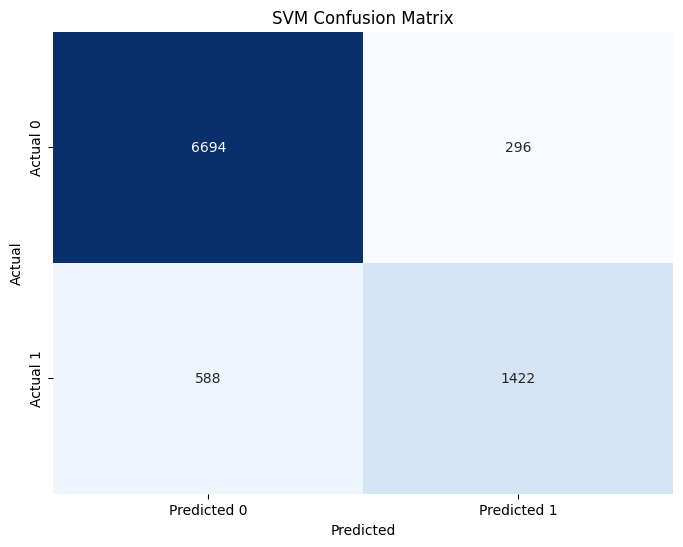

In [10]:
# 🧠 Step 8: 모델 학습 및 평가
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, Y_pred))

model2 = SVC()
model2.fit(X_train, y_train)
Y_pred2 = model2.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, Y_pred2))

# Confusion Matrix 시각화
def plot_confusion(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion(confusion_matrix(y_test, Y_pred2), "SVM Confusion Matrix")

KNN Accuracy: 90.26%

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      6990
           1       0.79      0.76      0.78      2010

    accuracy                           0.90      9000
   macro avg       0.86      0.85      0.86      9000
weighted avg       0.90      0.90      0.90      9000



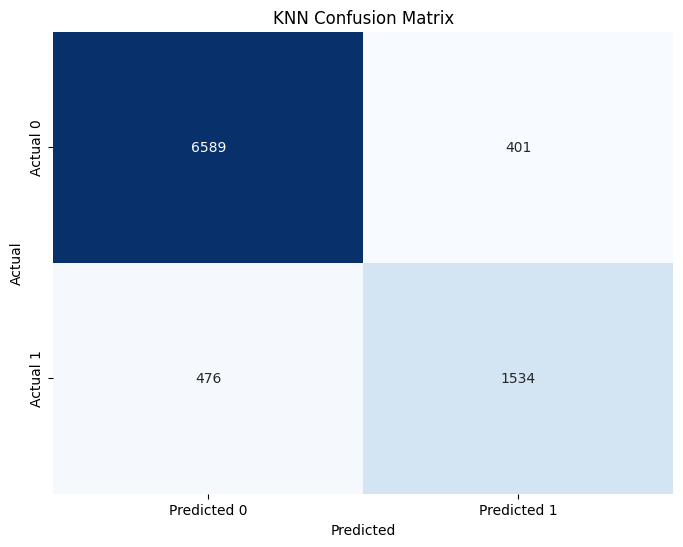

In [11]:
# 🧠 Step 9: KNN 모델 학습 및 평가
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(f'KNN Accuracy: {accuracy_score(y_test, y_pred_knn) * 100:.2f}%')
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
plot_confusion(confusion_matrix(y_test, y_pred_knn), "KNN Confusion Matrix")